In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import re
%matplotlib inline

In [2]:
#veritabanının eklenmesi
df = pd.DataFrame()
df = pd.read_excel (r'deprem_new_last.xlsx')
df

,Date,Tweet,Relevancy
0,2021-01-12 10:35:32,"b""'Omrumu yedi omrumu' diye bir replik vard ya...",1
1,\n2021-01-12 10:33:02,b'Buyuk Okyanus\nbuyukluk 5.2 MB (21 dk once)\...,1
2,\n2021-01-12 10:32:02,b'Buyuk Okyanus\nbuyukluk 4.8 M (9 dk once)\nd...,1
3,\n2021-01-12 10:29:39,b'Gecmis olsun Denizli #deprem',1
4,\n2021-01-12 10:28:02,"b'Sulawesi Utara, Endonezya\nbuyukluk 4.3 M (1...",1
...,...,...,...
6127,\n2021-01-10 20:56:40,b'Gecmis olsun Ankara\n#deprem',1
6128,\n2021-01-10 20:56:40,b'@RasimOzan_K RASIM ABI Gecmis olsun #Ankara\...,1
6129,\n2021-01-10 20:56:39,b'Gecmis olsun #Ankara #deprem',1
6130,\n2021-01-10 20:56:39,"b'Gecmis olsun Ankara, Allah devamini nasip et...",1


In [3]:
#stringler küçük harflere indirgendi
df['Tweet']=df['Tweet'].str.lower()

In [4]:
df['Tweet'][400]

'b" denizli\'nin pamukkale ilcesinde 4 buyuklugunde #deprem meydana geldi. https://t.co/oiz23rptnb https://t.co/tnkxp76ddl"'

In [5]:
# drop date
df = df.drop(['Date'], axis=1)

df['Tweet']=df['Tweet'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6132 entries, 0 to 6131
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      6132 non-null   object
 1   Relevancy  6132 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.9+ KB


In [6]:
# b' text ' silindi
def bas_son_sil(tweet):
    tweet = tweet[2:]
    tweet = tweet[:-1]
    return tweet

In [7]:
#tweetlerin içerisindeki mentionlar çıkarıldı
def mention_sil(tweet):
    tweet = re.sub(r'@\w+', '', tweet)
    return tweet

In [8]:
#tweetlerin içerisindeki hashtagler çıkarıldı
def hashtag_sil(tweet):
    tweet = re.sub(r'#\w+', '', tweet)
    return tweet

In [9]:
#url le çıkarıldı
def url_sil(tweet):
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', tweet)#bağlantıların çıkarılması
    return tweet

In [10]:
#özel karakterlerin çıkarılması(noktalama vs)
def punc_sil(tweet):
    tweet = re.sub('[^a-zığüşiöç\s]', '', tweet)
    tweet = re.sub(r"Â", "A", tweet)
    tweet = re.sub(r"â", "a", tweet)
    tweet = re.sub(r"Î", "I", tweet)
    tweet = re.sub(r"î", "ı", tweet)
    tweet = re.sub(r"Û", "U", tweet)
    tweet = re.sub(r"û", "u", tweet)
    return tweet

In [11]:
# java virtual machine kullanılarak zemberek uygulaması ile tokenization ve stemming yapıldı
import zemberek
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
#Zemberek kütüphanesinin kullanılabilmesi için Jpype ile JVM oluşturulması
ZEMBEREK_PATH = r'zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
#Morphology kütüphanesini kullanacağımızdan burada oluşturuyoruz
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()

In [12]:
# java virtual machine kullanılarak zemberek uygulaması ile tokenization ve stemming yapıldı
def stem_vm(tweet):
    arr=[]
    textlist=tweet.split(" ")
    if(tweet=='        '):
        tweet='bos'
    analysis: java.util.ArrayList = ( morphology.analyzeAndDisambiguate(tweet).bestAnalysis() )
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}' 
        arr.append(f'{str(analysis.getLemmas()[0])}')
    return arr

In [13]:
#stopwords çıkarma işlemi yapıldı
from nltk.corpus import stopwords
stopwords= set(stopwords.words("turkish"))
def stopwords_sil(tweet):
    tweet=[w for w in tweet if w.lower() not in stopwords]
    return tweet

In [14]:
def cleaner(tweet):
    tweet=tweet
    tweet=bas_son_sil(tweet)
    tweet=mention_sil(tweet)#mentionların çıkartırılması
    #tweet=hashtag_sil(tweet)#hashtagların çıkartılması
    tweet=url_sil(tweet)#bağlantıların çıkarılması
    tweet=punc_sil(tweet)#özel karakterlerin ve sayıların çıkarılması
    tweet=stem_vm(tweet)#kelime köklerinin bulunması
    tweet=stopwords_sil(tweet)#durak kelimelerin elenmesi
    tweet=' '.join(tweet)
    return tweet

In [15]:
#datasete yukarıda tanımlanan işlemler uygulandı
for i in range(0,len(df['Tweet'])):
    tweet = df['Tweet'][i]
    tweet = cleaner(tweet)
    #tweet=bas_son_sil(tweet)
    #tweet=mention_sil(tweet)
    #tweet=hashtag_sil(tweet)
    #tweet=url_sil(tweet)
    #tweet=punc_sil(tweet)
    #tweet=emoji_sil(tweet)
    #tweet=stem_vm(tweet)
    #tweet=stopwords_sil(tweet)
    #tweet=' '.join(tweet)
    df.at[i,'Tweet'] = tweet

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score

In [17]:
df

,Tweet,Relevancy
0,UNK yedi UNK bir replik UNK hani aynen UNK hat...,1
1,buyuk UNK mb dk UNK km n ocak UNK,1
2,buyuk UNK m dk UNK km s ocak UNK,1
3,gecmis ol denizli deprem,1
4,UNK UNK UNK m dk UNK km n ocak,1
...,...,...
6127,gecmis ol UNK,1
6128,rasim abi gecmis ol UNK meydan gel UNK deprem ...,1
6129,gecmis ol ankara deprem,1
6130,gecmis ol ankara allah UNK nasip et deprem uyu...,1


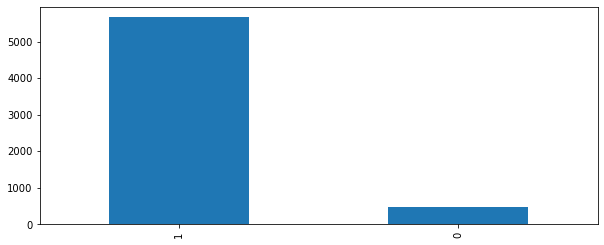

In [18]:
labels = [0,1]
plt.figure(figsize=(10,4))
df.Relevancy.value_counts().plot(kind='bar');

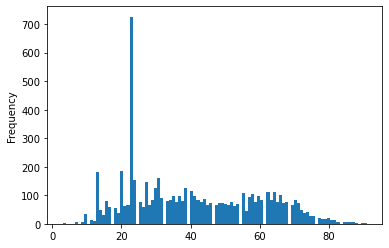

In [19]:
df['Length']=df['Tweet'].apply(len)
df['Length'].plot(bins=100, kind='hist')

In [20]:
def draw_conf(conf_mat, title):
    fig, ax = plt.subplots(figsize=(5,5))
    
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                xticklabels={1,0},
                yticklabels={1,0})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title+' \n', size=16);

In [21]:
X = df['Tweet']
Y = df['Relevancy']

2021-07-09 11:26:21,816 - numexpr.utils - INFO
Msg: NumExpr defaulting to 4 threads.



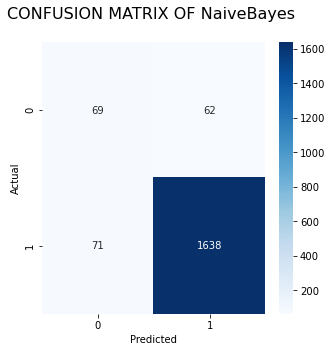

In [22]:
#tweet vectorization with countvectorizer
t=CountVectorizer()
tweets=t.fit_transform(df['Tweet']).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(tweets, Y, test_size=0.3, random_state = 44)
#modelin eğitilmesi
nbc=MultinomialNB()
nbc.fit(X_train,Y_train)
from sklearn.metrics import classification_report,confusion_matrix
preds=nbc.predict(X_test)
conf_mat = confusion_matrix(Y_test, preds)


draw_conf(conf_mat, 'CONFUSION MATRIX OF NaiveBayes') 

In [23]:
print(classification_report(Y_test,preds))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51       131
           1       0.96      0.96      0.96      1709

    accuracy                           0.93      1840
   macro avg       0.73      0.74      0.74      1840
weighted avg       0.93      0.93      0.93      1840



In [24]:
nbc.predict(t.transform(["yengeye elif dedin usta"]))

array([0], dtype=int64)

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        94
           1       0.96      0.97      0.96      1133

    accuracy                           0.93      1227
   macro avg       0.77      0.74      0.75      1227
weighted avg       0.93      0.93      0.93      1227

              precision    recall  f1-score   support

           0       0.50      0.61      0.55        94
           1       0.97      0.95      0.96      1133

    accuracy                           0.92      1227
   macro avg       0.73      0.78      0.75      1227
weighted avg       0.93      0.92      0.93      1227

              precision    recall  f1-score   support

           0       0.61      0.53      0.57        94
           1       0.96      0.97      0.97      1132

    accuracy                           0.94      1226
   macro avg       0.79      0.75      0.77      1226
weighted avg       0.93      0.94      0.94      1226

              preci

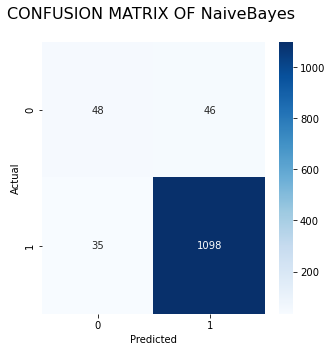

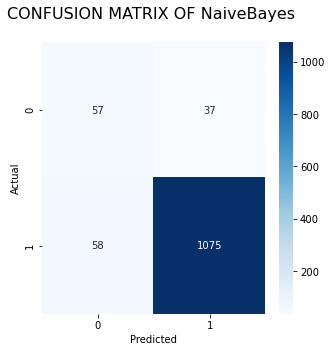

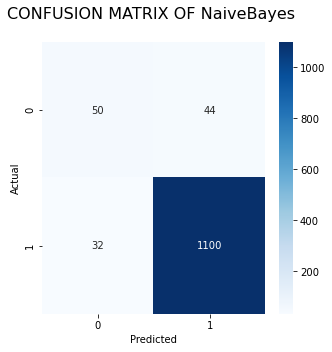

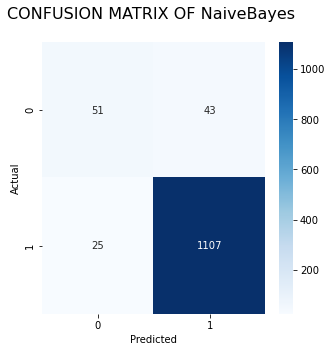

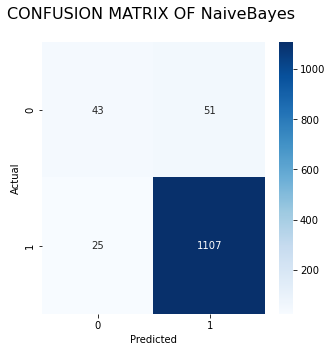

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold
X2 = df['Tweet']
Y2 = df['Relevancy']

metrics2 = []
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.3, random_state = 44)

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, Y):
    X_train2, X_test2 = X[train_index], X[test_index]
    Y_train2, Y_test2 = Y[train_index], Y[test_index]
    t2 = CountVectorizer()
    X_train2_dtm = t2.fit_transform(X_train2)
    X_test2_dtm = t2.transform(X_test2)
    nbc2 = MultinomialNB()
    nbc2.fit(X_train2_dtm, Y_train2)
    preds2 = nbc2.predict(X_test2_dtm)
    conf_mat2 = confusion_matrix(Y_test2, preds2)
    draw_conf(conf_mat2, 'CONFUSION MATRIX OF NaiveBayes')
    print(classification_report(Y_test2,preds2))

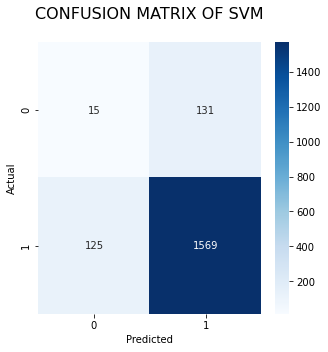

In [26]:
#tweet vectorization with countvectorizer
t=CountVectorizer().fit(df['Tweet'])
tweets=t.transform(df['Tweet'])

X_train, X_test, Y_train, Y_test = train_test_split(tweets, df['Relevancy'], test_size = 0.3)
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

Y_pred = svm.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(Y_test,Y_pred)

svm=confusion_matrix(Y_test,preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(svm, annot=True, cmap="Blues", fmt='d',
            xticklabels={1,0},
            yticklabels={1,0})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX OF SVM\n", size=16);

In [27]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.40      0.48       146
           1       0.95      0.98      0.96      1694

    accuracy                           0.93      1840
   macro avg       0.78      0.69      0.72      1840
weighted avg       0.92      0.93      0.93      1840



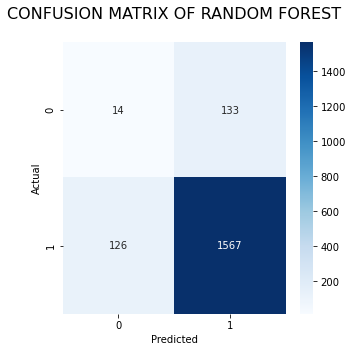

In [28]:
#tweet vectorization with countvectorizer
t=CountVectorizer().fit(df['Tweet'])
tweets=t.transform(df['Tweet'])

X_train, X_test, Y_train, Y_test = train_test_split(tweets, Y, test_size = 0.3)
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=110)
rfc.fit(X_train,Y_train)
Y_pred=rfc.predict(X_test)
rfc_conf_mat=confusion_matrix(Y_test,preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rfc_conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={1,0},
            yticklabels={1,0})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX OF RANDOM FOREST\n", size=16);

In [29]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.72      0.24      0.37       147
           1       0.94      0.99      0.96      1693

    accuracy                           0.93      1840
   macro avg       0.83      0.62      0.66      1840
weighted avg       0.92      0.93      0.92      1840

